# 4. Using subdomain scheduling - (1+1)D Burgers' equation

This notebook shows you how to use subdomains scheduling to train a FBPINN.

# What is subdomain scheduling?

An advantage of using domain decomposition for FBPINNs is that we can control which **parts** of the domain are solved at each training step.

This is useful if we want to control how boundary conditions are **communicated** across the domain.

For example, we can define a **time-stepping scheduler** to solve time-dependent PDEs, and learn the solution forwards in time from a set of initial conditions (see gif below).

This is done by specifying a **subdomain scheduler** (from `fbpinns.schedulers`), which defines which subdomains are actively training and which subdomains have fixed parameters at each training step.

# Problem overview

In this example we will use a time-stepping subdomain scheduler to train a FBPINN to solve the (1+1)D time-dependent Burgers' equation:

<img src="../images/scheduling.gif" width="70%">

The exact partial differential equation (PDE) and boundary conditions we will solve for are:

$$
\dfrac{\partial u}{\partial t} + u \dfrac{\partial u}{\partial x} = \nu \dfrac{\partial^2 u}{\partial x^2}
$$

Where $u(x,t)$ is the speed of the fluid and $\nu$ defines the scalar viscosity of the flow.

This exact problem is already defined in the `fbpinns.problems.BurgersEquation2D` problem class.

# Workflow overview

We will use the following steps to define a scheduler and train the FBPINN:
1. Define a `fbpinns.schedulers.ActiveScheduler` class
2. Train the FBPINN using this `ActiveScheduler` class

## Step 1: Define a `fbpinns.schedulers.ActiveScheduler` class

### Inheriting the `ActiveScheduler` class

All scheduler classes should inherit from the base `fbpinns.schedulers.ActiveScheduler` class:

```python
class ActiveScheduler:
    """Base scheduler class to be inherited by different schedulers"""

    def __init__(self, all_params, n_steps):
        self.n_steps = n_steps
        self.m = all_params["static"]["decomposition"]["m"]
        self.xd = all_params["static"]["decomposition"]["xd"]

    def __len__(self):
        return self.n_steps

    def __iter__(self):
        """
        Returns None if active array not to be changed, otherwise active array.
        active is an array of length m, where each value corresponds
        to the state of each model (i.e. subdomain), which can be one of:

        0 = inactive (but still trained if it overlaps with active models)
        1 = active
        2 = fixed
        """

        raise NotImplementedError
```

`ActiveScheduler`s are simply **Python iterables** which output an `active` array, which is a flat vector which indicates which subdomains are active or fixed at each training step.

During training, the scheduler is iterated over and if the `active` array changes, the input training points to the FBPINN and the trained subdomains are changed appropriately.

The length of the active array should equal the number of subdomains in the FBPINN, which is stored in the `all_params["static"]["decomposition"]["m"]` parameter.

### Using a pre-defined `ActiveScheduler`

There are some pre-defined `ActiveScheduler`s in `fbpinns.schedulers`. In particular for the problem above we can use `fbinns.schedulers.LineSchedulerRectangularND` to time-step, which is appropriate for the `RectangularDecompositionND` class.

In this case all we need to do is define the initialisation values of the class:

```python
scheduler_kwargs = dict(
    point=[0.], iaxis=0,
)
```

which indicates the starting time of the scheduler ($t=0$) and the axis along which the line of active models is defined (the $x$-axis). 

## Step 2: Train the FBPINN using this `ActiveScheduler` class

Finally, we can train a `FBPINN` using this `ActiveScheduler` class:

[INFO] 2025-03-26 16:38:21 - <fbpinns.constants.Constants object at 0x72a866b8f350>
run: test
domain: <class 'fbpinns.domains.RectangularDomainND'>
domain_init_kwargs: {'xmin': array([-1.,  0.]), 'xmax': array([1., 1.])}
problem: <class 'fbpinns.problems.BurgersEquation2D'>
problem_init_kwargs: {}
decomposition: <class 'fbpinns.decompositions.RectangularDecompositionND'>
decomposition_init_kwargs: {'subdomain_xs': [array([-1.        , -0.89473684, -0.78947368, -0.68421053, -0.57894737,
       -0.47368421, -0.36842105, -0.26315789, -0.15789474, -0.05263158,
        0.05263158,  0.15789474,  0.26315789,  0.36842105,  0.47368421,
        0.57894737,  0.68421053,  0.78947368,  0.89473684,  1.        ]), array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])], 'subdomain_ws': [array([0.30526316, 0.30526316, 0.30526316, 0.30526316, 0.30526316,
       0.30526316, 0.30526316, 0.30526316, 0.30526316, 0.30526316,
   

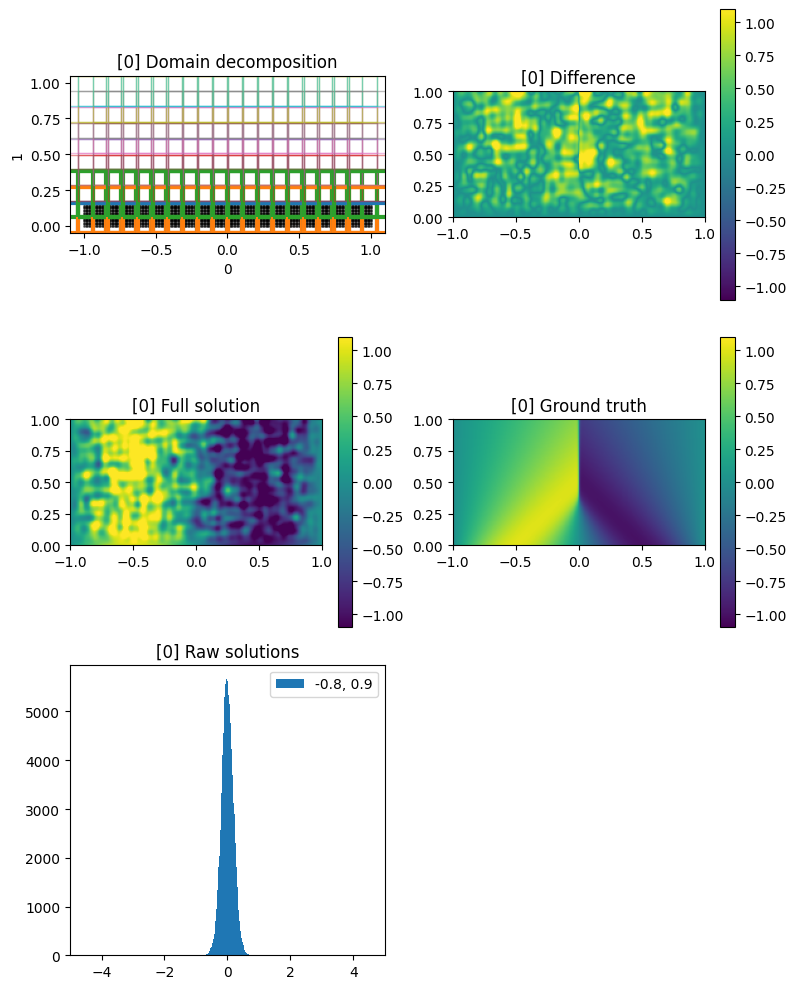

[INFO] 2025-03-26 16:38:37 - saved arrays
[INFO] 2025-03-26 16:38:37 - [i: 1000/100000] loss: 0.0047 rate: 219.2 elapsed: 0.00 hr test
[INFO] 2025-03-26 16:38:37 - [i: 2000/100000] loss: 0.0010 rate: 4953.8 elapsed: 0.00 hr test
[INFO] 2025-03-26 16:38:37 - [i: 3000/100000] loss: 0.0004 rate: 4955.2 elapsed: 0.00 hr test
[INFO] 2025-03-26 16:38:38 - [i: 4000/100000] loss: 0.0002 rate: 4936.7 elapsed: 0.00 hr test
[INFO] 2025-03-26 16:38:38 - [i: 5000/100000] loss: 0.0002 rate: 4953.7 elapsed: 0.00 hr test
True


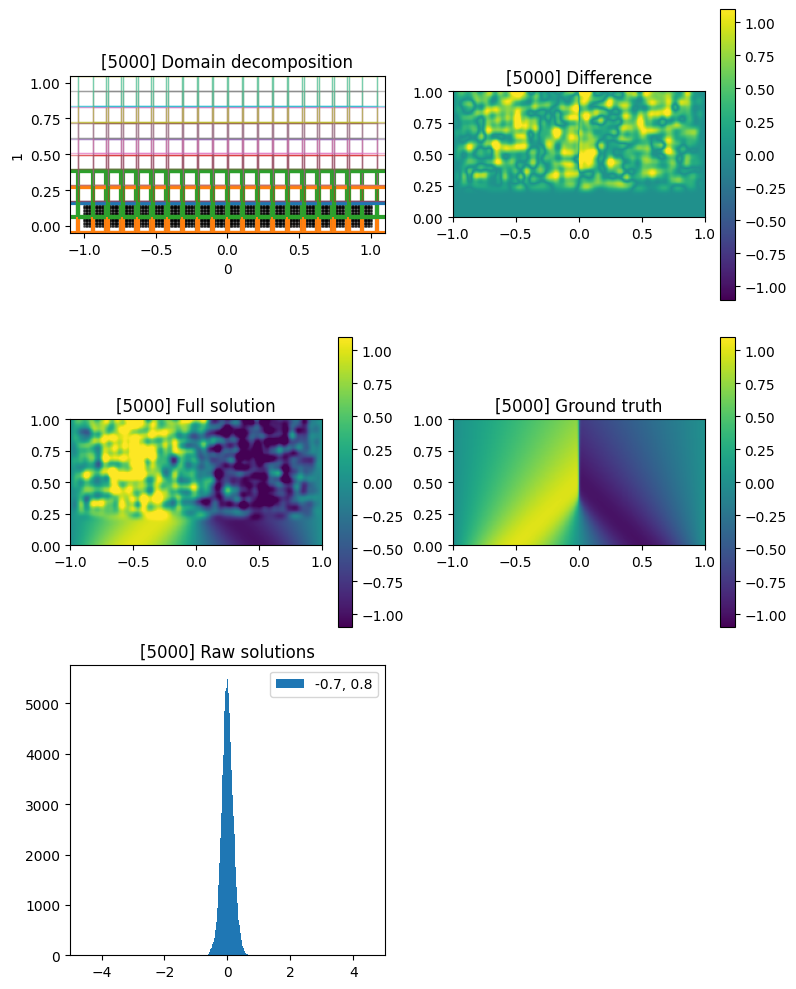

[INFO] 2025-03-26 16:38:39 - saved arrays
[INFO] 2025-03-26 16:38:39 - [i: 5264/100000] Updating active inputs..
[INFO] 2025-03-26 16:38:39 - [i: 5264/100000] Average number of points/dimension in active subdomains: 27.74
[INFO] 2025-03-26 16:38:41 - [i: 5264/100000] Updating active inputs done (2.49 s)
[INFO] 2025-03-26 16:38:41 - [i: 5264/100000] Compiling update step..
[INFO] 2025-03-26 16:38:41 - x_batch
[INFO] 2025-03-26 16:38:41 - (5400, 2), float32, JVPTracer
[INFO] 2025-03-26 16:38:41 - x_take
[INFO] 2025-03-26 16:38:41 - (41040, 2), float32, JVPTracer
[INFO] 2025-03-26 16:38:41 - x_batch
[INFO] 2025-03-26 16:38:41 - (5400, 2), float32, JVPTracer
[INFO] 2025-03-26 16:38:41 - x_take
[INFO] 2025-03-26 16:38:41 - (41040, 2), float32, JVPTracer
[INFO] 2025-03-26 16:38:43 - [i: 5264/100000] Compiling done (2.07 s)
[INFO] 2025-03-26 16:38:43 - [i: 6000/100000] loss: 0.0018 rate: 206.2 elapsed: 0.00 hr test
[INFO] 2025-03-26 16:38:44 - [i: 7000/100000] loss: 0.0007 rate: 3423.7 elapse

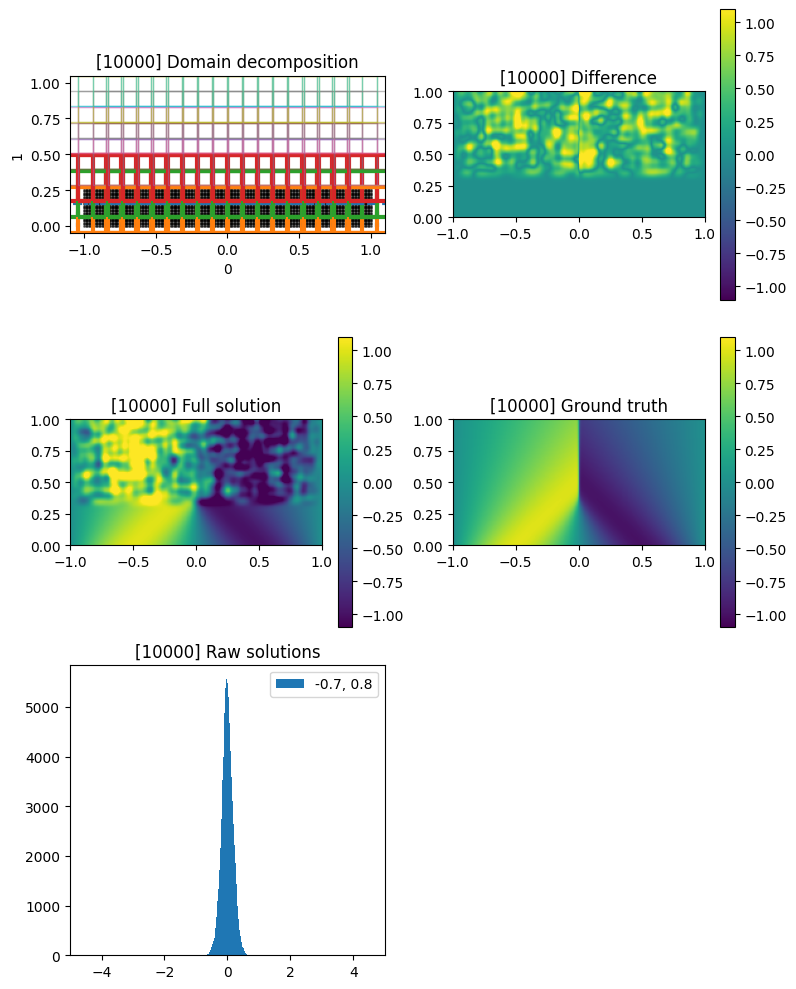

[INFO] 2025-03-26 16:38:45 - saved arrays
[INFO] 2025-03-26 16:38:46 - [i: 11000/100000] loss: 0.0003 rate: 3421.7 elapsed: 0.00 hr test
[INFO] 2025-03-26 16:38:46 - [i: 12000/100000] loss: 0.0003 rate: 3424.8 elapsed: 0.00 hr test
[INFO] 2025-03-26 16:38:46 - [i: 13000/100000] loss: 0.0003 rate: 3430.0 elapsed: 0.00 hr test
[INFO] 2025-03-26 16:38:47 - [i: 14000/100000] loss: 0.0003 rate: 3434.2 elapsed: 0.00 hr test
[INFO] 2025-03-26 16:38:47 - [i: 15000/100000] loss: 0.0003 rate: 3446.5 elapsed: 0.00 hr test
True


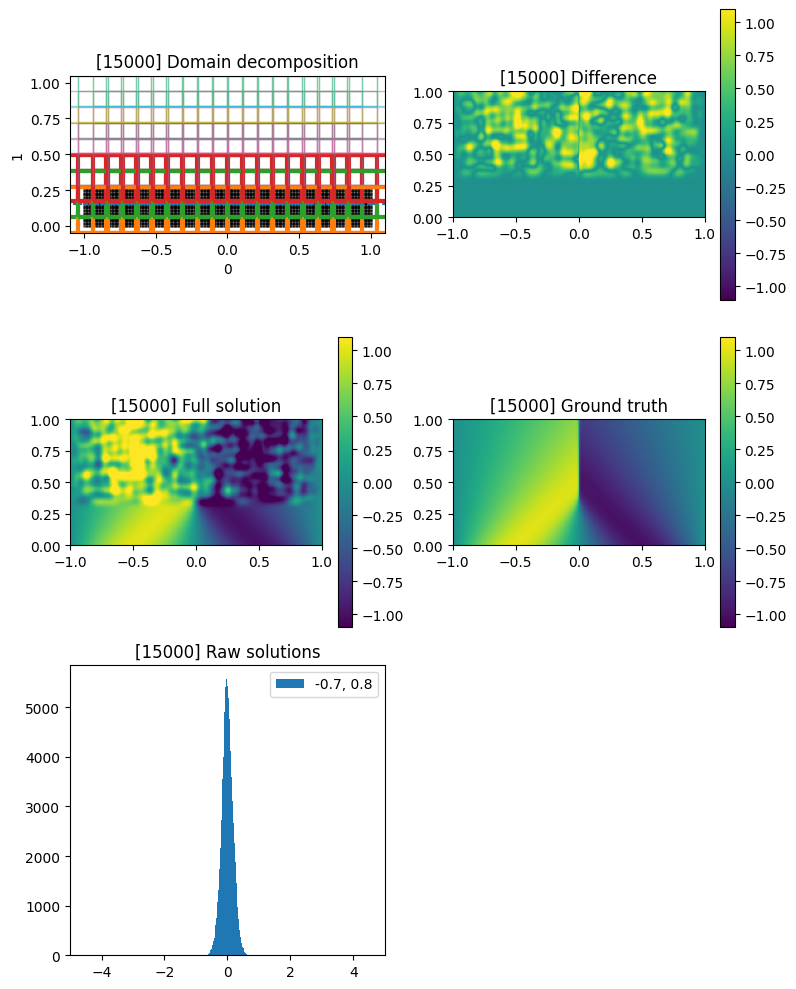

[INFO] 2025-03-26 16:38:48 - saved arrays
[INFO] 2025-03-26 16:38:48 - [i: 15790/100000] Updating active inputs..
[INFO] 2025-03-26 16:38:48 - [i: 15790/100000] Average number of points/dimension in active subdomains: 29.72
[INFO] 2025-03-26 16:38:51 - [i: 15790/100000] Updating active inputs done (2.60 s)
[INFO] 2025-03-26 16:38:51 - [i: 15790/100000] Compiling update step..
[INFO] 2025-03-26 16:38:51 - x_batch
[INFO] 2025-03-26 16:38:51 - (6200, 2), float32, JVPTracer
[INFO] 2025-03-26 16:38:51 - x_take
[INFO] 2025-03-26 16:38:51 - (50730, 2), float32, JVPTracer
[INFO] 2025-03-26 16:38:51 - x_batch
[INFO] 2025-03-26 16:38:51 - (6200, 2), float32, JVPTracer
[INFO] 2025-03-26 16:38:51 - x_take
[INFO] 2025-03-26 16:38:51 - (50730, 2), float32, JVPTracer
[INFO] 2025-03-26 16:38:53 - [i: 15790/100000] Compiling done (2.24 s)
[INFO] 2025-03-26 16:38:53 - [i: 16000/100000] loss: 0.0441 rate: 194.5 elapsed: 0.01 hr test
[INFO] 2025-03-26 16:38:53 - [i: 17000/100000] loss: 0.0344 rate: 3032.7

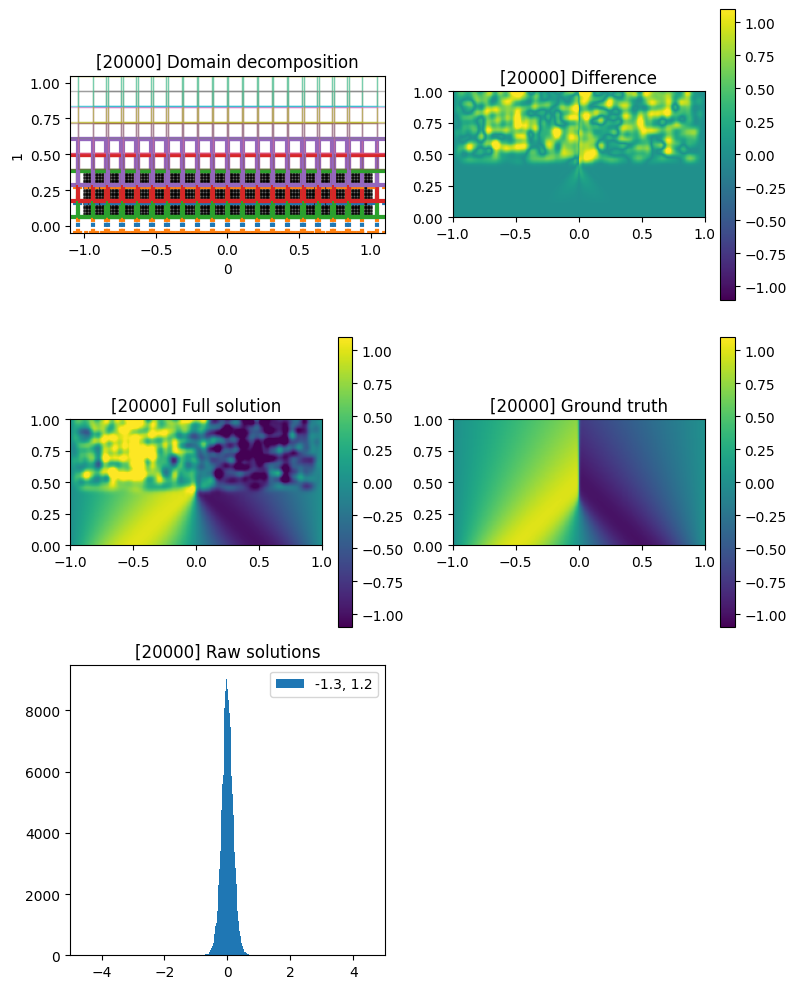

[INFO] 2025-03-26 16:38:55 - saved arrays
[INFO] 2025-03-26 16:38:55 - [i: 21000/100000] loss: 0.0319 rate: 3087.3 elapsed: 0.01 hr test
[INFO] 2025-03-26 16:38:56 - [i: 22000/100000] loss: 0.0317 rate: 3083.9 elapsed: 0.01 hr test
[INFO] 2025-03-26 16:38:56 - [i: 23000/100000] loss: 0.0315 rate: 3086.8 elapsed: 0.01 hr test
[INFO] 2025-03-26 16:38:56 - [i: 24000/100000] loss: 0.0321 rate: 3081.1 elapsed: 0.01 hr test
[INFO] 2025-03-26 16:38:57 - [i: 25000/100000] loss: 0.0312 rate: 3077.5 elapsed: 0.01 hr test
True


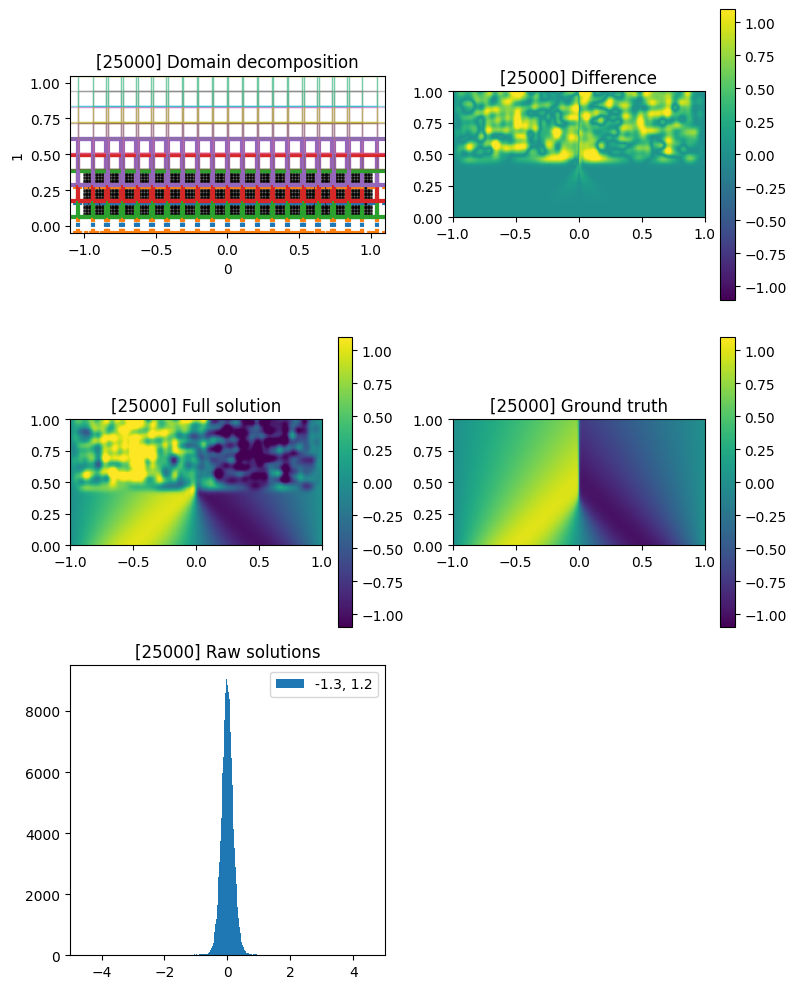

[INFO] 2025-03-26 16:38:58 - saved arrays
[INFO] 2025-03-26 16:38:58 - [i: 26000/100000] loss: 0.0312 rate: 3085.7 elapsed: 0.01 hr test
[INFO] 2025-03-26 16:38:58 - [i: 26316/100000] Updating active inputs..
[INFO] 2025-03-26 16:38:58 - [i: 26316/100000] Average number of points/dimension in active subdomains: 29.72
[INFO] 2025-03-26 16:38:58 - [i: 26316/100000] Updating active inputs done (0.21 s)
[INFO] 2025-03-26 16:38:58 - [i: 26316/100000] Compiling update step..
[INFO] 2025-03-26 16:38:58 - [i: 26316/100000] Compiling done (0.03 s)
[INFO] 2025-03-26 16:38:59 - [i: 27000/100000] loss: 0.2394 rate: 1775.7 elapsed: 0.01 hr test
[INFO] 2025-03-26 16:38:59 - [i: 28000/100000] loss: 0.2293 rate: 3088.6 elapsed: 0.01 hr test
[INFO] 2025-03-26 16:38:59 - [i: 29000/100000] loss: 0.2262 rate: 3087.5 elapsed: 0.01 hr test
[INFO] 2025-03-26 16:39:00 - [i: 30000/100000] loss: 0.2250 rate: 3079.7 elapsed: 0.01 hr test
True


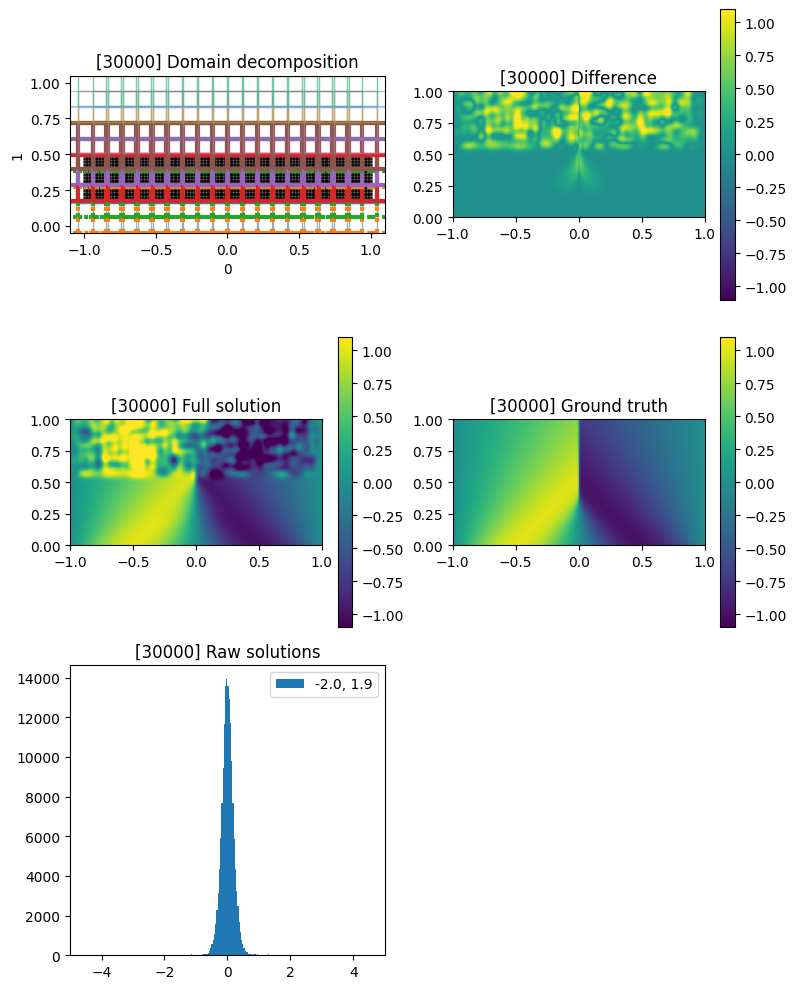

[INFO] 2025-03-26 16:39:00 - saved arrays
[INFO] 2025-03-26 16:39:01 - [i: 31000/100000] loss: 0.2240 rate: 3079.2 elapsed: 0.01 hr test
[INFO] 2025-03-26 16:39:01 - [i: 32000/100000] loss: 0.2232 rate: 3083.4 elapsed: 0.01 hr test
[INFO] 2025-03-26 16:39:01 - [i: 33000/100000] loss: 0.2231 rate: 3080.2 elapsed: 0.01 hr test
[INFO] 2025-03-26 16:39:02 - [i: 34000/100000] loss: 0.2221 rate: 3075.1 elapsed: 0.01 hr test
[INFO] 2025-03-26 16:39:02 - [i: 35000/100000] loss: 0.2205 rate: 3079.7 elapsed: 0.01 hr test
True


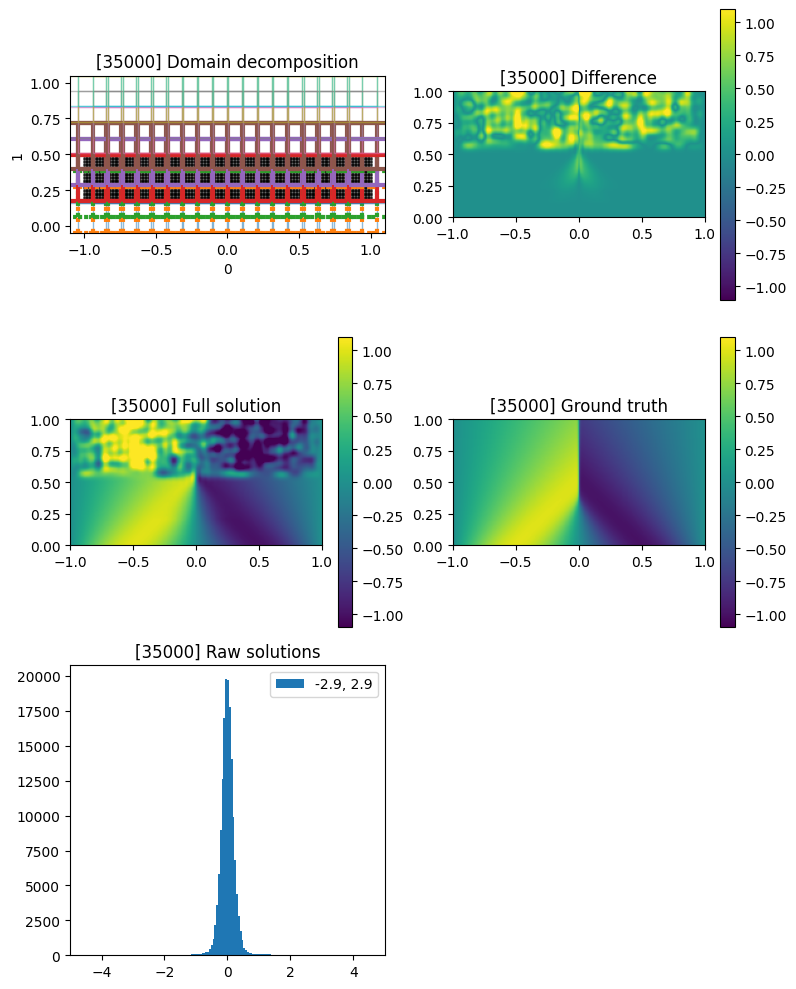

[INFO] 2025-03-26 16:39:03 - saved arrays
[INFO] 2025-03-26 16:39:03 - [i: 36000/100000] loss: 0.2197 rate: 3081.3 elapsed: 0.01 hr test
[INFO] 2025-03-26 16:39:03 - [i: 36843/100000] Updating active inputs..
[INFO] 2025-03-26 16:39:03 - [i: 36843/100000] Average number of points/dimension in active subdomains: 29.72
[INFO] 2025-03-26 16:39:03 - [i: 36843/100000] Updating active inputs done (0.04 s)
[INFO] 2025-03-26 16:39:03 - [i: 36843/100000] Compiling update step..
[INFO] 2025-03-26 16:39:03 - [i: 36843/100000] Compiling done (0.03 s)
[INFO] 2025-03-26 16:39:03 - [i: 37000/100000] loss: 0.4530 rate: 2555.3 elapsed: 0.01 hr test
[INFO] 2025-03-26 16:39:04 - [i: 38000/100000] loss: 0.3953 rate: 3068.2 elapsed: 0.01 hr test
[INFO] 2025-03-26 16:39:04 - [i: 39000/100000] loss: 0.3901 rate: 3075.1 elapsed: 0.01 hr test
[INFO] 2025-03-26 16:39:04 - [i: 40000/100000] loss: 0.3876 rate: 3081.8 elapsed: 0.01 hr test
True


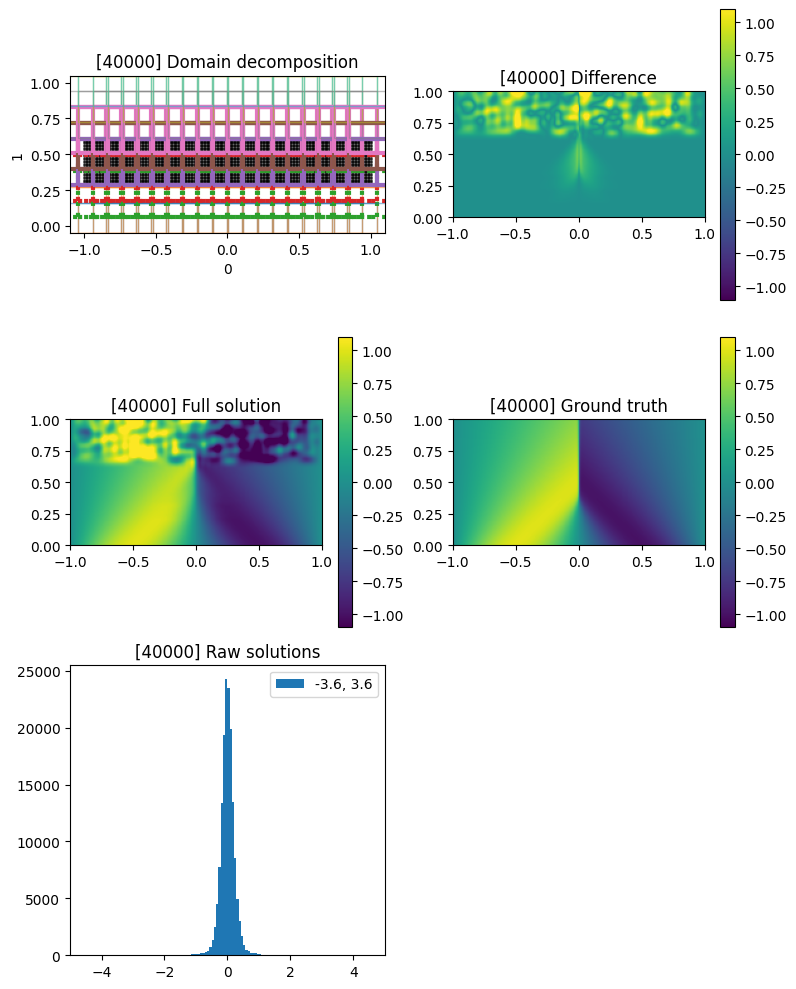

[INFO] 2025-03-26 16:39:05 - saved arrays
[INFO] 2025-03-26 16:39:05 - [i: 41000/100000] loss: 0.3858 rate: 3085.1 elapsed: 0.01 hr test
[INFO] 2025-03-26 16:39:06 - [i: 42000/100000] loss: 0.3843 rate: 3077.7 elapsed: 0.01 hr test
[INFO] 2025-03-26 16:39:06 - [i: 43000/100000] loss: 0.3828 rate: 3078.2 elapsed: 0.01 hr test
[INFO] 2025-03-26 16:39:06 - [i: 44000/100000] loss: 0.3813 rate: 3077.0 elapsed: 0.01 hr test
[INFO] 2025-03-26 16:39:07 - [i: 45000/100000] loss: 0.3799 rate: 3075.8 elapsed: 0.01 hr test
True


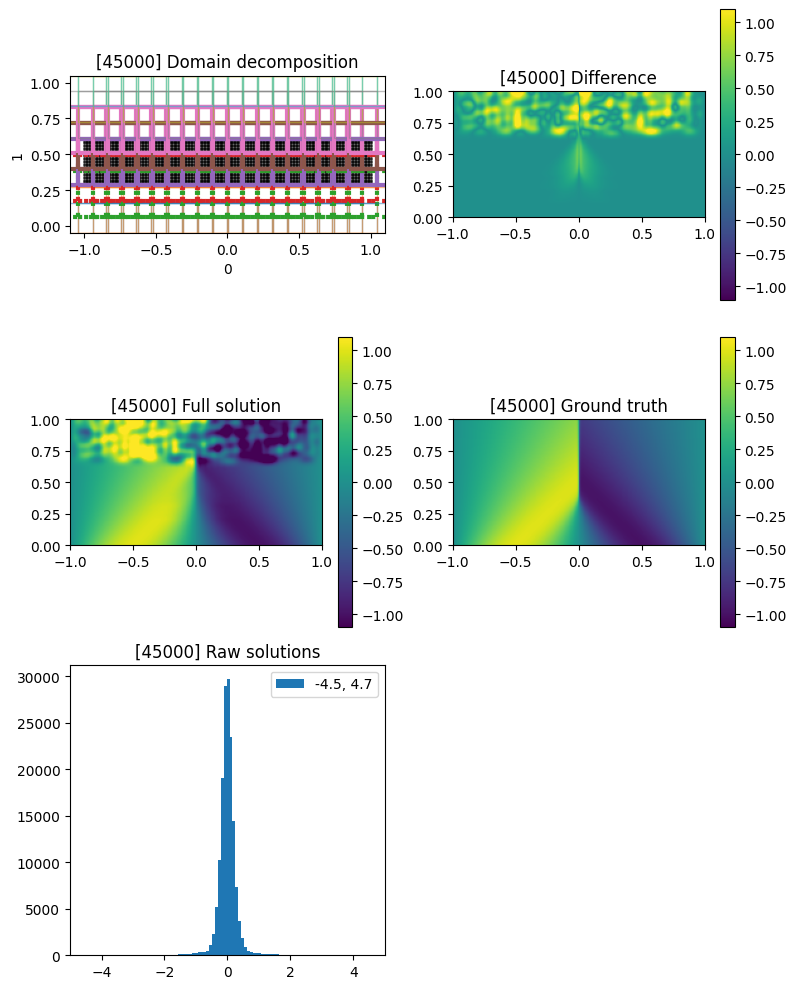

[INFO] 2025-03-26 16:39:08 - saved arrays
[INFO] 2025-03-26 16:39:08 - [i: 46000/100000] loss: 0.3788 rate: 3079.7 elapsed: 0.01 hr test
[INFO] 2025-03-26 16:39:08 - [i: 47000/100000] loss: 0.3772 rate: 3082.2 elapsed: 0.01 hr test
[INFO] 2025-03-26 16:39:08 - [i: 47369/100000] Updating active inputs..
[INFO] 2025-03-26 16:39:08 - [i: 47369/100000] Average number of points/dimension in active subdomains: 29.72
[INFO] 2025-03-26 16:39:08 - [i: 47369/100000] Updating active inputs done (0.04 s)
[INFO] 2025-03-26 16:39:08 - [i: 47369/100000] Compiling update step..
[INFO] 2025-03-26 16:39:08 - [i: 47369/100000] Compiling done (0.03 s)
[INFO] 2025-03-26 16:39:09 - [i: 48000/100000] loss: 0.4441 rate: 2531.5 elapsed: 0.01 hr test
[INFO] 2025-03-26 16:39:09 - [i: 49000/100000] loss: 0.4288 rate: 3074.6 elapsed: 0.01 hr test
[INFO] 2025-03-26 16:39:09 - [i: 50000/100000] loss: 0.4247 rate: 3074.9 elapsed: 0.01 hr test
True


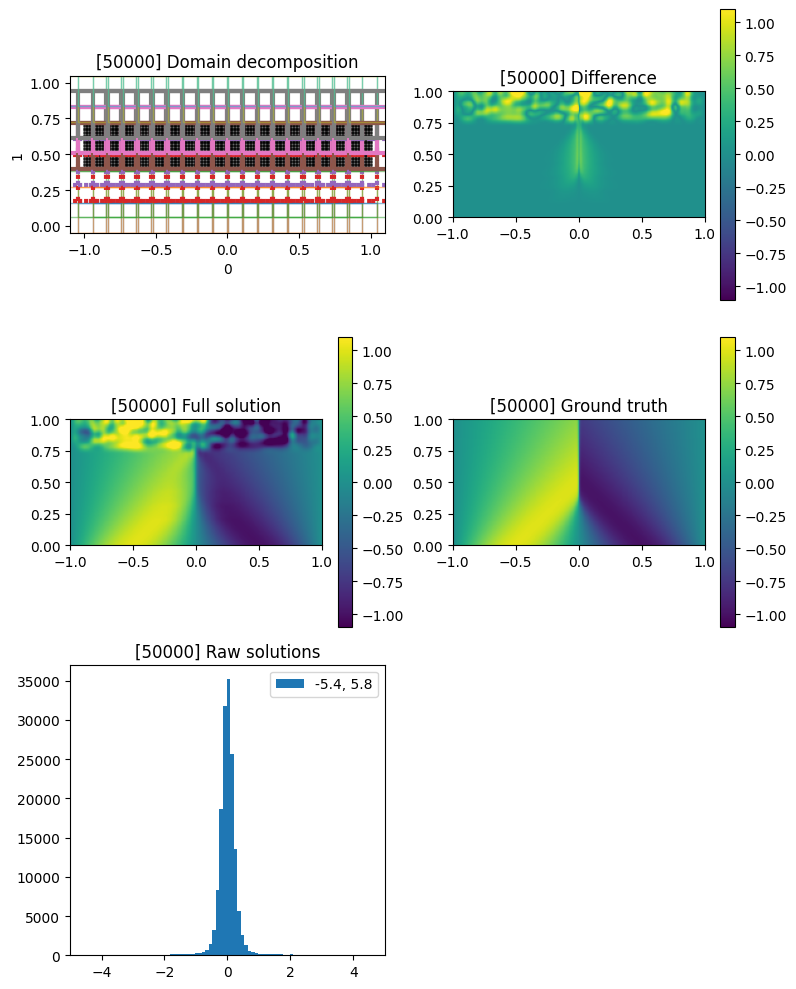

[INFO] 2025-03-26 16:39:10 - saved arrays
[INFO] 2025-03-26 16:39:11 - [i: 51000/100000] loss: 0.4223 rate: 3056.5 elapsed: 0.01 hr test
[INFO] 2025-03-26 16:39:11 - [i: 52000/100000] loss: 0.4203 rate: 3075.3 elapsed: 0.01 hr test
[INFO] 2025-03-26 16:39:11 - [i: 53000/100000] loss: 0.4185 rate: 3072.8 elapsed: 0.01 hr test
[INFO] 2025-03-26 16:39:12 - [i: 54000/100000] loss: 0.4167 rate: 3066.3 elapsed: 0.01 hr test
[INFO] 2025-03-26 16:39:12 - [i: 55000/100000] loss: 0.4158 rate: 3068.3 elapsed: 0.01 hr test
True


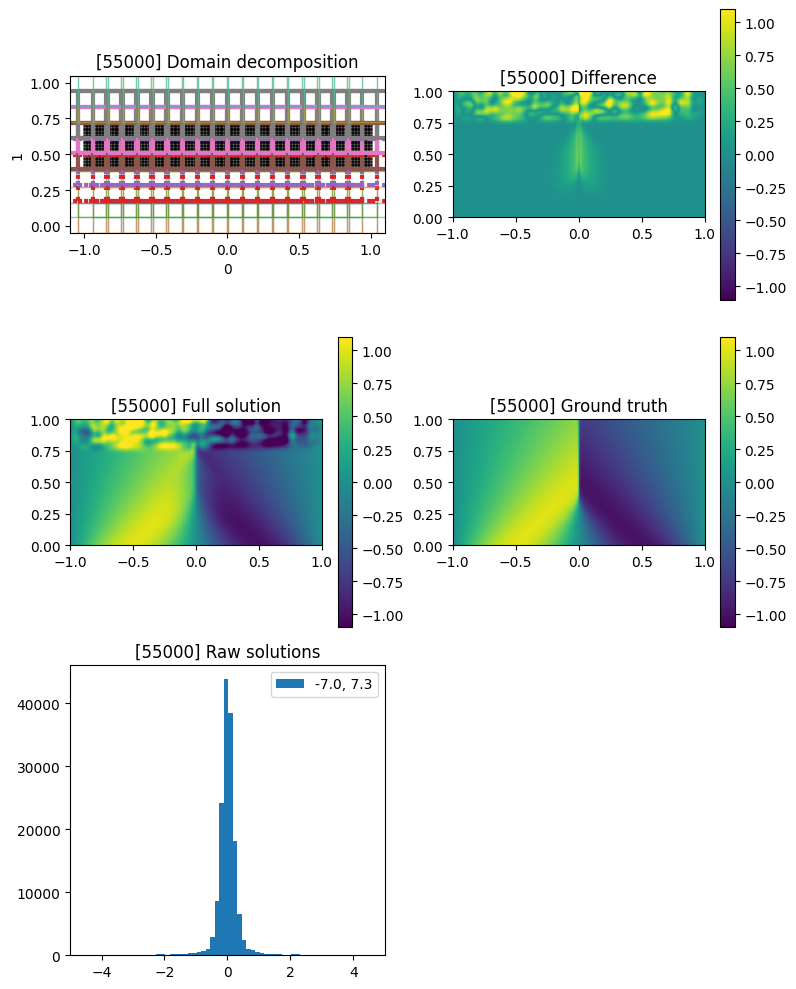

[INFO] 2025-03-26 16:39:13 - saved arrays
[INFO] 2025-03-26 16:39:13 - [i: 56000/100000] loss: 0.4139 rate: 3075.8 elapsed: 0.01 hr test
[INFO] 2025-03-26 16:39:13 - [i: 57000/100000] loss: 0.4116 rate: 3063.5 elapsed: 0.01 hr test
[INFO] 2025-03-26 16:39:14 - [i: 57895/100000] Updating active inputs..
[INFO] 2025-03-26 16:39:14 - [i: 57895/100000] Average number of points/dimension in active subdomains: 29.72
[INFO] 2025-03-26 16:39:14 - [i: 57895/100000] Updating active inputs done (0.04 s)
[INFO] 2025-03-26 16:39:14 - [i: 57895/100000] Compiling update step..
[INFO] 2025-03-26 16:39:14 - [i: 57895/100000] Compiling done (0.03 s)
[INFO] 2025-03-26 16:39:14 - [i: 58000/100000] loss: 0.4178 rate: 2521.1 elapsed: 0.01 hr test
[INFO] 2025-03-26 16:39:14 - [i: 59000/100000] loss: 0.3663 rate: 3079.4 elapsed: 0.01 hr test
[INFO] 2025-03-26 16:39:14 - [i: 60000/100000] loss: 0.3629 rate: 3069.3 elapsed: 0.01 hr test
True


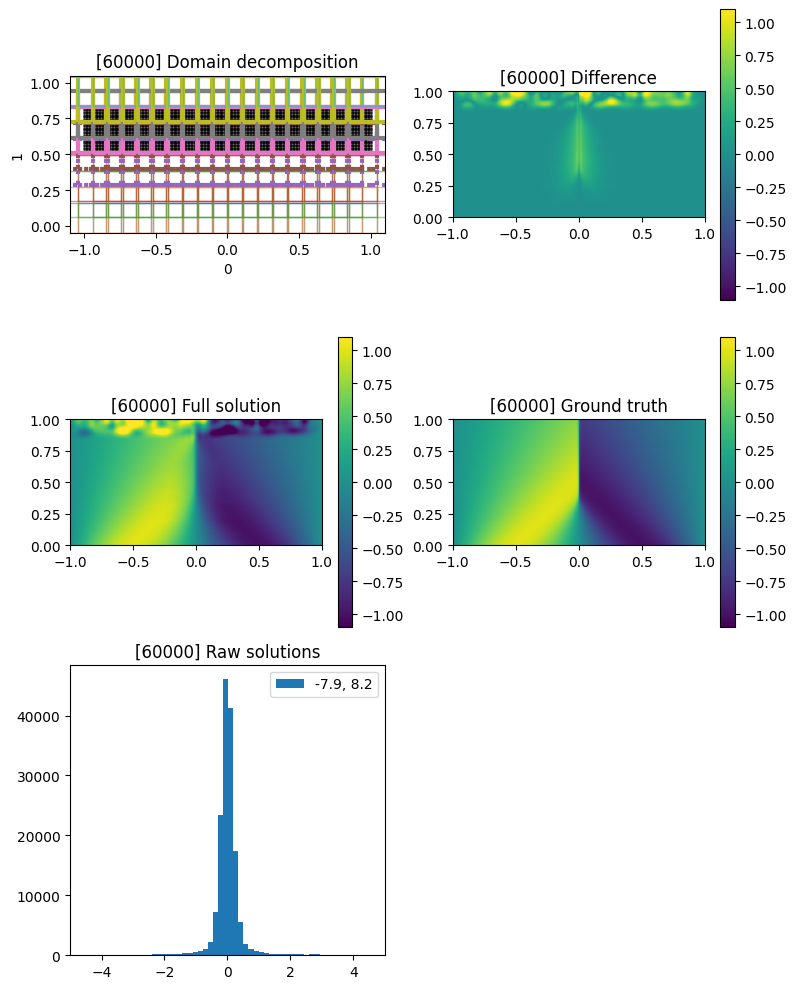

[INFO] 2025-03-26 16:39:15 - saved arrays
[INFO] 2025-03-26 16:39:15 - [i: 61000/100000] loss: 0.3612 rate: 3069.9 elapsed: 0.01 hr test
[INFO] 2025-03-26 16:39:16 - [i: 62000/100000] loss: 0.3597 rate: 3074.7 elapsed: 0.01 hr test
[INFO] 2025-03-26 16:39:16 - [i: 63000/100000] loss: 0.3582 rate: 3077.5 elapsed: 0.01 hr test
[INFO] 2025-03-26 16:39:16 - [i: 64000/100000] loss: 0.3570 rate: 3071.1 elapsed: 0.01 hr test
[INFO] 2025-03-26 16:39:17 - [i: 65000/100000] loss: 0.3550 rate: 3079.9 elapsed: 0.01 hr test
True


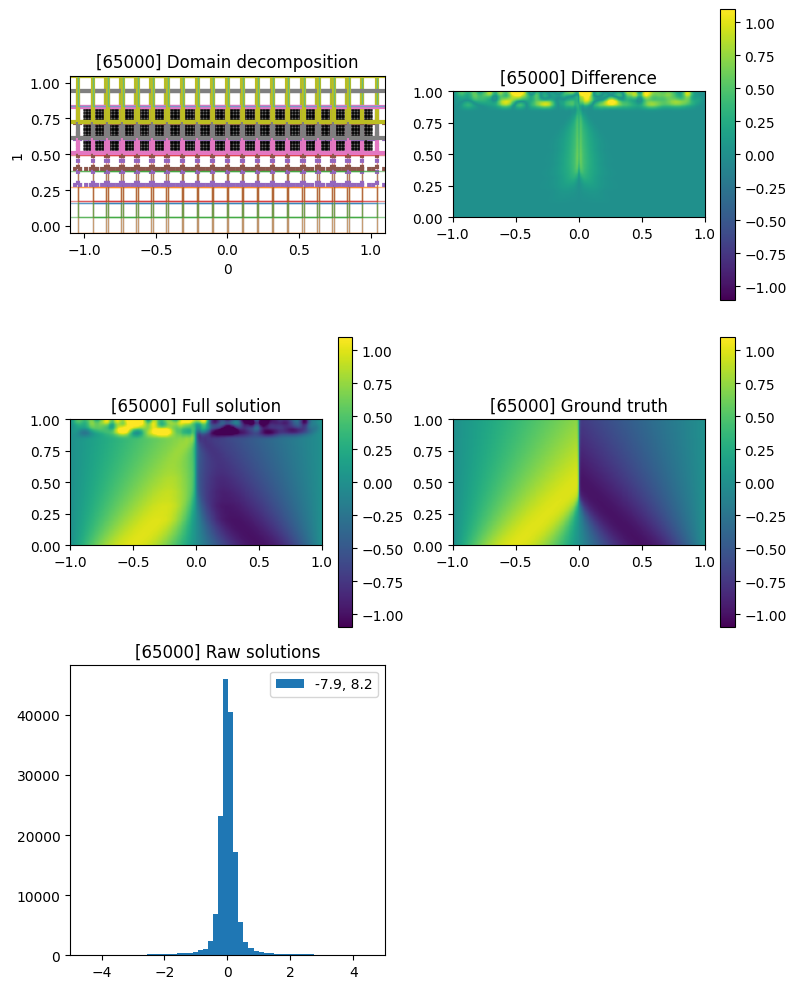

[INFO] 2025-03-26 16:39:17 - saved arrays
[INFO] 2025-03-26 16:39:18 - [i: 66000/100000] loss: 0.3550 rate: 3069.6 elapsed: 0.01 hr test
[INFO] 2025-03-26 16:39:18 - [i: 67000/100000] loss: 0.3521 rate: 3077.0 elapsed: 0.01 hr test
[INFO] 2025-03-26 16:39:19 - [i: 68000/100000] loss: 0.3507 rate: 3071.6 elapsed: 0.01 hr test
[INFO] 2025-03-26 16:39:19 - [i: 68422/100000] Updating active inputs..
[INFO] 2025-03-26 16:39:19 - [i: 68422/100000] Average number of points/dimension in active subdomains: 29.72
[INFO] 2025-03-26 16:39:19 - [i: 68422/100000] Updating active inputs done (0.12 s)
[INFO] 2025-03-26 16:39:19 - [i: 68422/100000] Compiling update step..
[INFO] 2025-03-26 16:39:19 - [i: 68422/100000] Compiling done (0.03 s)
[INFO] 2025-03-26 16:39:19 - [i: 69000/100000] loss: 0.2888 rate: 2117.6 elapsed: 0.01 hr test
[INFO] 2025-03-26 16:39:19 - [i: 70000/100000] loss: 0.2807 rate: 3086.6 elapsed: 0.01 hr test
True


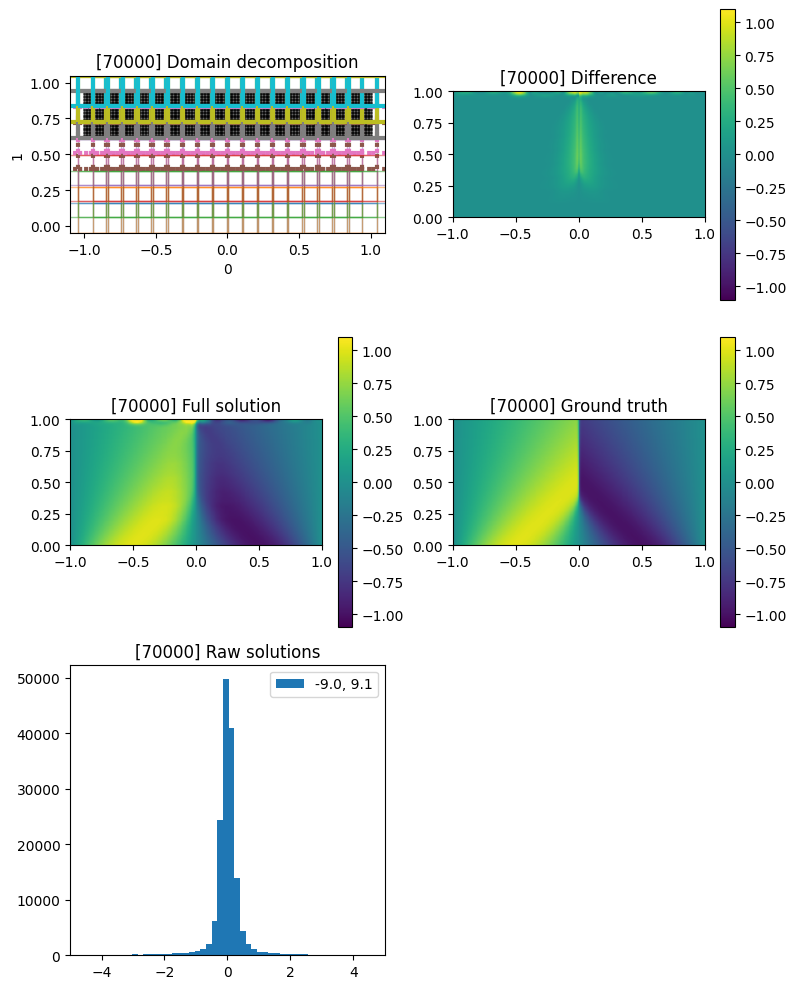

[INFO] 2025-03-26 16:39:20 - saved arrays
[INFO] 2025-03-26 16:39:20 - [i: 71000/100000] loss: 0.2784 rate: 3086.1 elapsed: 0.01 hr test
[INFO] 2025-03-26 16:39:21 - [i: 72000/100000] loss: 0.2771 rate: 3080.6 elapsed: 0.01 hr test
[INFO] 2025-03-26 16:39:21 - [i: 73000/100000] loss: 0.2760 rate: 3088.5 elapsed: 0.01 hr test
[INFO] 2025-03-26 16:39:21 - [i: 74000/100000] loss: 0.2746 rate: 3086.9 elapsed: 0.01 hr test
[INFO] 2025-03-26 16:39:22 - [i: 75000/100000] loss: 0.2737 rate: 3078.1 elapsed: 0.01 hr test
True


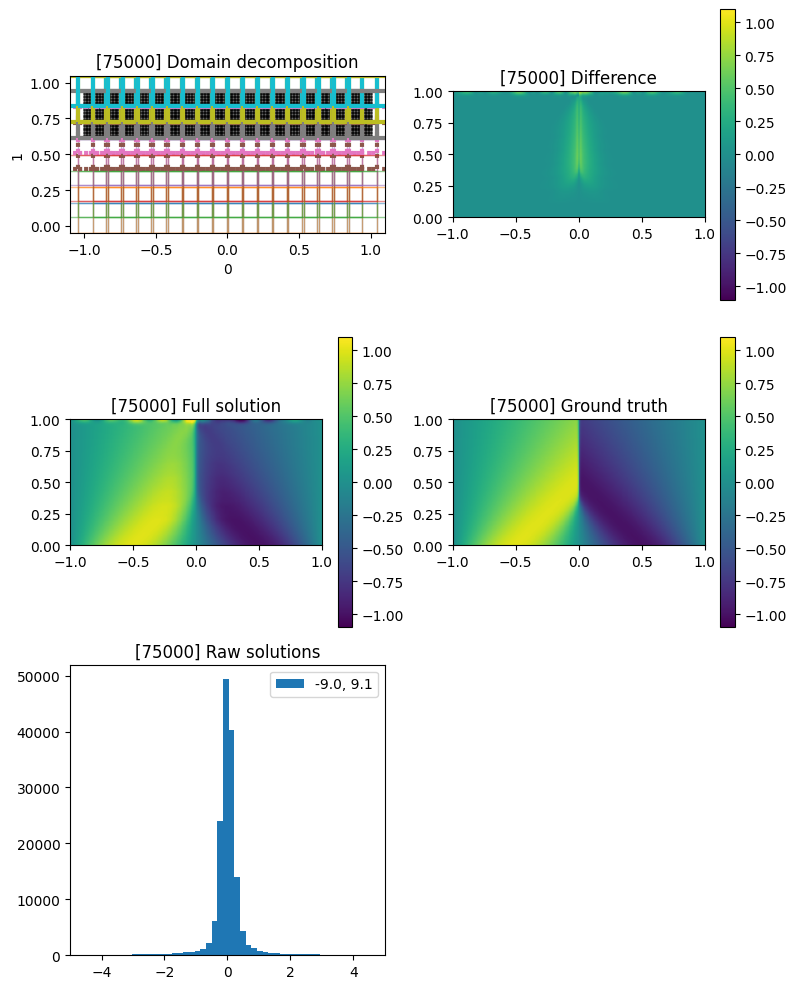

[INFO] 2025-03-26 16:39:23 - saved arrays
[INFO] 2025-03-26 16:39:23 - [i: 76000/100000] loss: 0.2720 rate: 4789.5 elapsed: 0.01 hr test
[INFO] 2025-03-26 16:39:23 - [i: 77000/100000] loss: 0.2704 rate: 4732.2 elapsed: 0.01 hr test
[INFO] 2025-03-26 16:39:23 - [i: 78000/100000] loss: 0.2690 rate: 4710.0 elapsed: 0.01 hr test
[INFO] 2025-03-26 16:39:24 - [i: 78948/100000] Updating active inputs..
[INFO] 2025-03-26 16:39:24 - [i: 78948/100000] Average number of points/dimension in active subdomains: 27.74
[INFO] 2025-03-26 16:39:24 - [i: 78948/100000] Updating active inputs done (0.13 s)
[INFO] 2025-03-26 16:39:24 - [i: 78948/100000] Compiling update step..
[INFO] 2025-03-26 16:39:24 - x_batch
[INFO] 2025-03-26 16:39:24 - (5400, 2), float32, JVPTracer
[INFO] 2025-03-26 16:39:24 - x_take
[INFO] 2025-03-26 16:39:24 - (41040, 2), float32, JVPTracer
[INFO] 2025-03-26 16:39:24 - x_batch
[INFO] 2025-03-26 16:39:24 - (5400, 2), float32, JVPTracer
[INFO] 2025-03-26 16:39:24 - x_take
[INFO] 2025-

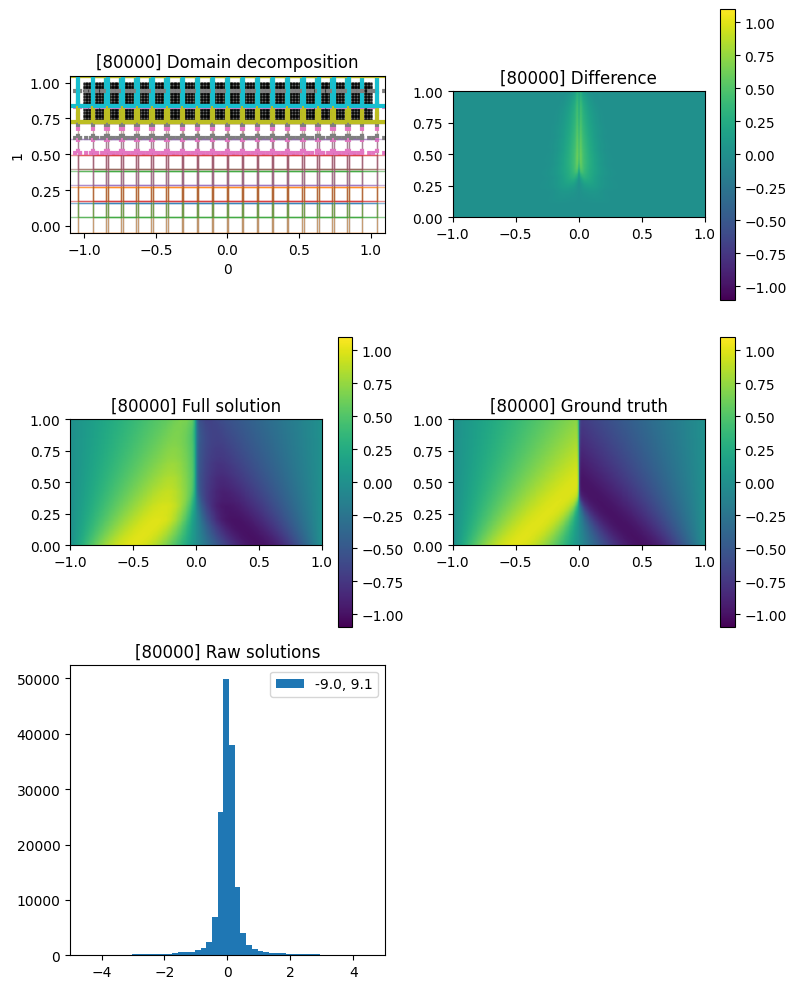

[INFO] 2025-03-26 16:39:27 - saved arrays
[INFO] 2025-03-26 16:39:27 - [i: 81000/100000] loss: 0.2153 rate: 4642.7 elapsed: 0.02 hr test
[INFO] 2025-03-26 16:39:27 - [i: 82000/100000] loss: 0.2145 rate: 4658.0 elapsed: 0.02 hr test
[INFO] 2025-03-26 16:39:27 - [i: 83000/100000] loss: 0.2136 rate: 4636.4 elapsed: 0.02 hr test
[INFO] 2025-03-26 16:39:27 - [i: 84000/100000] loss: 0.2124 rate: 4636.9 elapsed: 0.02 hr test
[INFO] 2025-03-26 16:39:28 - [i: 85000/100000] loss: 0.2111 rate: 4626.6 elapsed: 0.02 hr test
True


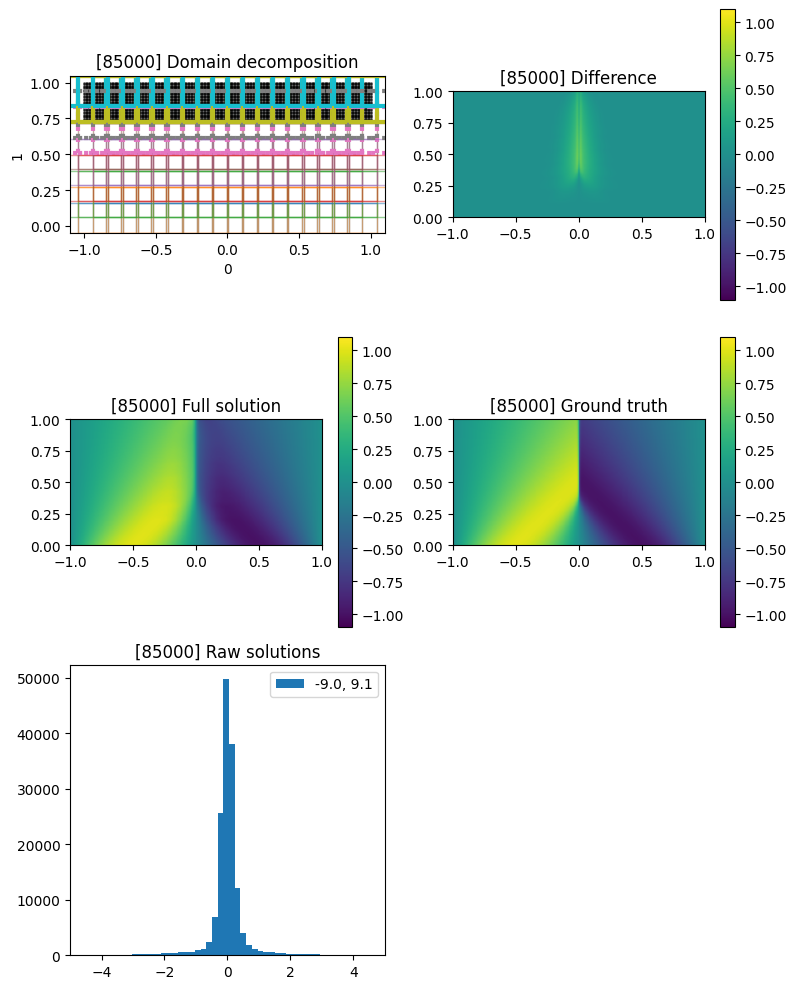

[INFO] 2025-03-26 16:39:28 - saved arrays
[INFO] 2025-03-26 16:39:29 - [i: 86000/100000] loss: 0.2101 rate: 4651.8 elapsed: 0.02 hr test
[INFO] 2025-03-26 16:39:29 - [i: 87000/100000] loss: 0.2084 rate: 4663.3 elapsed: 0.02 hr test
[INFO] 2025-03-26 16:39:29 - [i: 88000/100000] loss: 0.2073 rate: 4644.3 elapsed: 0.02 hr test
[INFO] 2025-03-26 16:39:29 - [i: 89000/100000] loss: 0.2057 rate: 4725.8 elapsed: 0.02 hr test
[INFO] 2025-03-26 16:39:29 - [i: 89474/100000] Updating active inputs..
[INFO] 2025-03-26 16:39:29 - [i: 89474/100000] Average number of points/dimension in active subdomains: 21.35
[INFO] 2025-03-26 16:39:29 - [i: 89474/100000] Updating active inputs done (0.07 s)
[INFO] 2025-03-26 16:39:29 - [i: 89474/100000] Compiling update step..
[INFO] 2025-03-26 16:39:29 - x_batch
[INFO] 2025-03-26 16:39:29 - (3200, 2), float32, JVPTracer
[INFO] 2025-03-26 16:39:29 - x_take
[INFO] 2025-03-26 16:39:29 - (23370, 2), float32, JVPTracer
[INFO] 2025-03-26 16:39:30 - x_batch
[INFO] 2025-

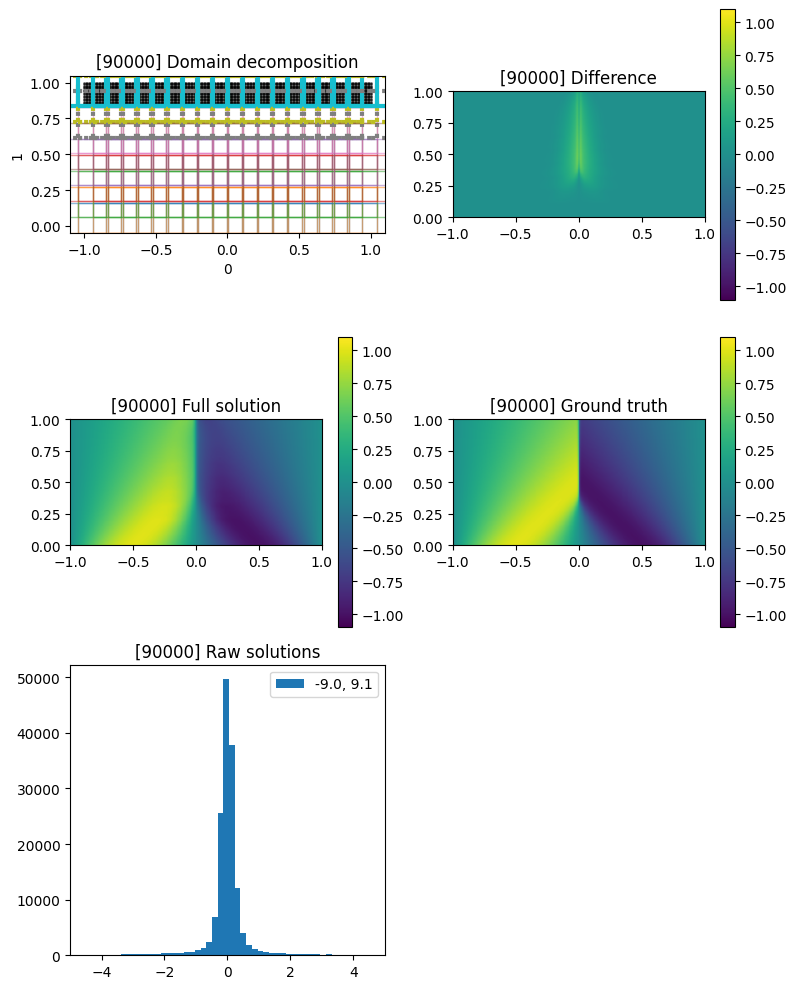

[INFO] 2025-03-26 16:39:32 - saved arrays
[INFO] 2025-03-26 16:39:32 - [i: 91000/100000] loss: 0.1508 rate: 7939.7 elapsed: 0.02 hr test
[INFO] 2025-03-26 16:39:32 - [i: 92000/100000] loss: 0.1491 rate: 7769.3 elapsed: 0.02 hr test
[INFO] 2025-03-26 16:39:32 - [i: 93000/100000] loss: 0.1474 rate: 7632.1 elapsed: 0.02 hr test
[INFO] 2025-03-26 16:39:32 - [i: 94000/100000] loss: 0.1460 rate: 7734.6 elapsed: 0.02 hr test
[INFO] 2025-03-26 16:39:33 - [i: 95000/100000] loss: 0.1445 rate: 7863.8 elapsed: 0.02 hr test
True


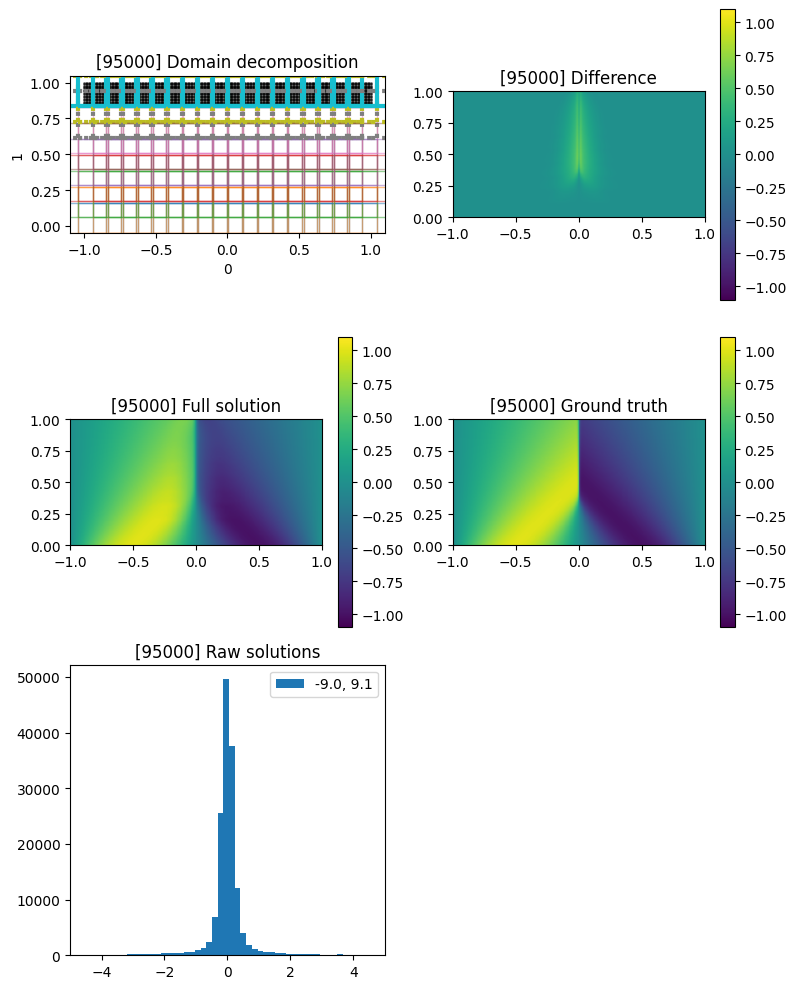

[INFO] 2025-03-26 16:39:33 - saved arrays
[INFO] 2025-03-26 16:39:33 - [i: 96000/100000] loss: 0.1432 rate: 7889.7 elapsed: 0.02 hr test
[INFO] 2025-03-26 16:39:34 - [i: 97000/100000] loss: 0.1419 rate: 7670.2 elapsed: 0.02 hr test
[INFO] 2025-03-26 16:39:34 - [i: 98000/100000] loss: 0.1406 rate: 7872.3 elapsed: 0.02 hr test
[INFO] 2025-03-26 16:39:34 - [i: 99000/100000] loss: 0.1394 rate: 7671.7 elapsed: 0.02 hr test
[INFO] 2025-03-26 16:39:34 - [i: 100000/100000] loss: 0.1384 rate: 7741.6 elapsed: 0.02 hr test
True


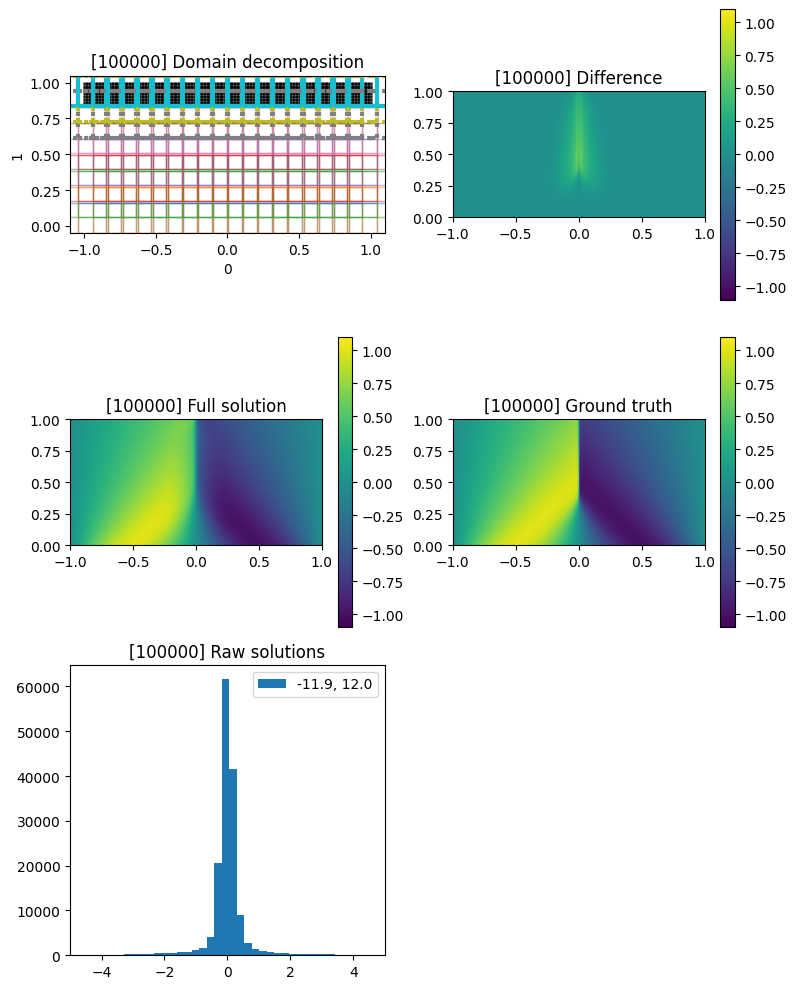

[INFO] 2025-03-26 16:39:35 - saved arrays
[INFO] 2025-03-26 16:39:35 - [i: 100000/100000] Training complete


In [1]:
import numpy as np

from fbpinns.domains import RectangularDomainND
from fbpinns.problems import BurgersEquation2D
from fbpinns.decompositions import RectangularDecompositionND
from fbpinns.networks import FCN, ChebyshevKAN
from fbpinns.schedulers import LineSchedulerRectangularND
from fbpinns.constants import Constants, get_subdomain_ws
from fbpinns.trainers import FBPINNTrainer

subdomain_xs=[np.linspace(-1,1,20), np.linspace(0,1,10)]
c = Constants(
    domain=RectangularDomainND,
    domain_init_kwargs = dict(
        xmin=np.array([-1,0.]),
        xmax=np.array([1.,1.])
        ),
    problem=BurgersEquation2D,
    problem_init_kwargs = dict(),
    decomposition=RectangularDecompositionND,
    decomposition_init_kwargs=dict(
        subdomain_xs=subdomain_xs,
        subdomain_ws=get_subdomain_ws(subdomain_xs, 2.9),
        unnorm=(0.,3.),
    ),
    # network=FCN,
    # network_init_kwargs = dict(
    #     layer_sizes = (2, 16, 1),
    # ),
    network=ChebyshevKAN,# place a fully-connected network in each subdomain
    network_init_kwargs=dict(
        input_dim=2,
        output_dim=1,
        degree=9
    ),
    scheduler = LineSchedulerRectangularND,
    scheduler_kwargs = dict(
        point=[0.], iaxis=0,
    ),
    ns=((200,100),),
    n_test=(200,100),
    n_steps=100000,
    clear_output=False,
)

run = FBPINNTrainer(c)
all_params = run.train()